In [1]:
import os
import gc
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

def encode_labels(target):

    ls = target['annotation']['object']
    j = []
    if isinstance(ls, dict):
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))
    else:
        for item in ls:
            if int(item['difficult']) == 0:
                j.append(object_categories.index(item['name']))

    k = np.zeros(len(object_categories))
    k[j] = 1
    return torch.from_numpy(k)

def get_ap_score(y_true, y_scores):

    scores = 0.0
    for i in range(y_true.shape[0]):
        scores += average_precision_score(y_true=y_true[i], y_score=y_scores[i])
    return scores

def plot_history(train_hist, val_hist, y_label, filename, labels=["train", "validation"]):

    xi = [i for i in range(0, len(train_hist), 2)]
    plt.figure()
    plt.plot(train_hist, label=labels[0])
    plt.plot(val_hist, label=labels[1])
    plt.xticks(xi)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.savefig(filename)
    plt.close()

def train_model(model, device, optimizer, scheduler, train_loader, valid_loader, save_dir, model_num, epochs, log_file):

    tr_loss, tr_map = [], []
    val_loss, val_map = [], []
    best_val_map = 0.0

    for epoch in range(epochs):
        print(f"-------Epoch {epoch+1}----------")
        log_file.write(f"Epoch {epoch+1} >>")
        scheduler.step()


        model.train(True)
        running_loss = 0.0
        running_ap = 0.0

        criterion = nn.BCEWithLogitsLoss(reduction='sum')
        m = nn.Sigmoid()

        for data, target in train_loader:
            target = target.float()
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)

            running_loss += loss
            running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(),
                                        torch.Tensor.cpu(m(output)).detach().numpy())

            loss.backward()
            optimizer.step()

            #
            del data, target, output
            gc.collect()
            torch.cuda.empty_cache()

        num_samples = float(len(train_loader.dataset))
        tr_loss_ = running_loss.item() / num_samples
        tr_map_ = running_ap / num_samples

        print(f'train_loss: {tr_loss_:.4f}, train_avg_precision:{tr_map_:.3f}')
        log_file.write(f'train_loss: {tr_loss_:.4f}, train_avg_precision:{tr_map_:.3f}, ')

        tr_loss.append(tr_loss_)
        tr_map.append(tr_map_)


        model.train(False)
        running_loss = 0.0
        running_ap = 0.0

        with torch.no_grad():
            for data, target in valid_loader:
                target = target.float()
                data, target = data.to(device), target.to(device)
                output = model(data)

                loss = criterion(output, target)

                running_loss += loss
                running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(),
                                            torch.Tensor.cpu(m(output)).detach().numpy())

                del data, target, output
                gc.collect()
                torch.cuda.empty_cache()

            num_samples = float(len(valid_loader.dataset))
            val_loss_ = running_loss.item() / num_samples
            val_map_ = running_ap / num_samples

            val_loss.append(val_loss_)
            val_map.append(val_map_)

            print(f'val_loss: {val_loss_:.4f}, val_avg_precision:{val_map_:.3f}')
            log_file.write(f'val_loss: {val_loss_:.4f}, val_avg_precision:{val_map_:.3f}\n')


            if val_map_ >= best_val_map:
                best_val_map = val_map_
                log_file.write("saving best weights...\n")
                torch.save(model.state_dict(), os.path.join(save_dir, f"model-{model_num}.pth"))

    return ([tr_loss, tr_map], [val_loss, val_map])

def main():

    data_dir = '/content/data'
    model_name = 'resnet50'
    num = 1
    lr = [1e-5, 5e-3]
    epochs = 15
    batch_size = 32
    download_data = True


    model_dir = os.path.join("models", model_name)
    os.makedirs(model_dir, exist_ok=True)


    model_urls = {
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
    }


    use_cuda = torch.cuda.is_available()
    np.random.seed(2019)
    torch.manual_seed(2019)
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Available device = {device}")


    model = models.resnet50()
    model.load_state_dict(model_zoo.load_url(model_urls[model_name]))
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 20)
    model.to(device)


    optimizer = optim.SGD([
        {'params': list(model.parameters())[:-1], 'lr': lr[0], 'momentum': 0.9},
        {'params': list(model.parameters())[-1], 'lr': lr[1], 'momentum': 0.9}
    ])


    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12, eta_min=0, last_epoch=-1)


    mean = [0.457342265910642, 0.4387686270106377, 0.4073427106250871]
    std = [0.26753769276329037, 0.2638145880487105, 0.2776826934044154]


    transformations = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.RandomChoice([
            transforms.ColorJitter(brightness=(0.80, 1.20)),
            transforms.RandomGrayscale(p=0.25)
        ]),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    transformations_valid = transforms.Compose([
        transforms.Resize(330),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])


    from dataset import PascalVOC_Dataset

    dataset_train = PascalVOC_Dataset(
        data_dir,
        year='2012',
        image_set='train',
        download=download_data,
        transform=transformations,
        target_transform=encode_labels
    )

    train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True)

    dataset_valid = PascalVOC_Dataset(
        data_dir,
        year='2012',
        image_set='val',
        download=download_data,
        transform=transformations_valid,
        target_transform=encode_labels
    )

    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, num_workers=4)


    log_file = open(os.path.join(model_dir, f"log-{num}.txt"), "w+")
    log_file.write(f"----------Experiment {num} - {model_name}-----------\n")
    log_file.write(f"transformations == {transformations}\n")


    trn_hist, val_hist = train_model(
        model, device, optimizer, scheduler,
        train_loader, valid_loader, model_dir, num, epochs, log_file
    )


    plot_history(trn_hist[0], val_hist[0], "Loss", os.path.join(model_dir, f"loss-{num}.png"))
    plot_history(trn_hist[1], val_hist[1], "Accuracy", os.path.join(model_dir, f"accuracy-{num}.png"))

    log_file.close()

if __name__ == "__main__":
    main()

Available device = cuda


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 261MB/s]


100%|██████████| 2.00G/2.00G [02:16<00:00, 14.7MB/s]


Extracting /content/data/VOCtrainval_11-May-2012.tar to /content/data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using downloaded and verified file: /content/data/VOCtrainval_11-May-2012.tar
Extracting /content/data/VOCtrainval_11-May-2012.tar to /content/data
-------Epoch 1----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train_loss: 4.3031, train_avg_precision:0.550


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 2.8751, val_avg_precision:0.790
-------Epoch 2----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 2.6538, train_avg_precision:0.813


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 2.0575, val_avg_precision:0.882
-------Epoch 3----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 2.1387, train_avg_precision:0.875


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.7672, val_avg_precision:0.912
-------Epoch 4----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.8756, train_avg_precision:0.900


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.6220, val_avg_precision:0.925
-------Epoch 5----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.7399, train_avg_precision:0.911


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.5254, val_avg_precision:0.931
-------Epoch 6----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.6250, train_avg_precision:0.924


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4708, val_avg_precision:0.935
-------Epoch 7----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.5477, train_avg_precision:0.929


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4432, val_avg_precision:0.936
-------Epoch 8----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.5074, train_avg_precision:0.931


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4090, val_avg_precision:0.938
-------Epoch 9----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4793, train_avg_precision:0.934


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4029, val_avg_precision:0.939
-------Epoch 10----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4563, train_avg_precision:0.936


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.3989, val_avg_precision:0.939
-------Epoch 11----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4504, train_avg_precision:0.938


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4013, val_avg_precision:0.940
-------Epoch 12----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4563, train_avg_precision:0.937


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.3991, val_avg_precision:0.939
-------Epoch 13----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4535, train_avg_precision:0.935


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.4141, val_avg_precision:0.939
-------Epoch 14----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4525, train_avg_precision:0.937


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.3954, val_avg_precision:0.940
-------Epoch 15----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train_loss: 1.4415, train_avg_precision:0.937


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val_loss: 1.3842, val_avg_precision:0.939


In [2]:
def plot_learning_rate(optimizer, filename):

    lr_history = []
    for param_group in optimizer.param_groups:
        lr_history.append([])

    plt.figure(figsize=(10, 6))
    for epoch in range(epochs):
        for i, param_group in enumerate(optimizer.param_groups):
            lr_history[i].append(param_group['lr'])
        scheduler.step()

    labels = ['Backbone LR', 'FC Layer LR']
    for i, lrs in enumerate(lr_history):
        plt.plot(lrs, label=labels[i])

    plt.title('Learning Rate Decay')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def plot_detailed_metrics(trn_hist, val_hist, metric_name, filename):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(trn_hist, label=f'Train {metric_name}', color='blue')
    plt.plot(val_hist, label=f'Validation {metric_name}', color='red')
    plt.title(f'{metric_name} Progression')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()


    plt.subplot(1, 2, 2)
    difference = [t - v for t, v in zip(trn_hist, val_hist)]
    plt.plot(difference, label=f'{metric_name} Difference', color='green')
    plt.title(f'{metric_name} Train-Validation Difference')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric_name} Difference')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()


def main():



    trn_hist, val_hist = train_model(
        model, device, optimizer, scheduler,
        train_loader, valid_loader, model_dir, num, epochs, log_file
    )


    plot_history(trn_hist[0], val_hist[0], "Loss", os.path.join(model_dir, f"loss-{num}.png"))
    plot_history(trn_hist[1], val_hist[1], "Accuracy", os.path.join(model_dir, f"accuracy-{num}.png"))


    plot_detailed_metrics(trn_hist[0], val_hist[0], "Loss", os.path.join(model_dir, f"detailed-loss-{num}.png"))
    plot_detailed_metrics(trn_hist[1], val_hist[1], "Accuracy", os.path.join(model_dir, f"detailed-accuracy-{num}.png"))


    plot_learning_rate(optimizer, os.path.join(model_dir, f"learning-rates-{num}.png"))

    log_file.close()

In [4]:
def plot_metrics(trn_hist, val_hist):

    plt.figure(figsize=(16, 10))


    plt.subplot(2, 2, 1)
    plt.plot(trn_hist[0], label='Train Loss', color='blue')
    plt.plot(val_hist[0], label='Validation Loss', color='red')
    plt.title('Loss Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(2, 2, 2)
    plt.plot(trn_hist[1], label='Train Accuracy', color='green')
    plt.plot(val_hist[1], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    lr_history = []
    for param_group in optimizer.param_groups:
        lr_history.append([])

    for epoch in range(epochs):
        for i, param_group in enumerate(optimizer.param_groups):
            lr_history[i].append(param_group['lr'])
        scheduler.step()

    plt.subplot(2, 2, 3)
    labels = ['Backbone LR', 'FC Layer LR']
    for i, lrs in enumerate(lr_history):
        plt.plot(lrs, label=labels[i])
    plt.title('Learning Rate Decay')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.subplot(2, 2, 4)
    loss_diff = [t - v for t, v in zip(trn_hist[0], val_hist[0])]
    plt.plot(loss_diff, label='Train-Validation Loss Difference', color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Loss Difference')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.legend()

    plt.tight_layout()
    plt.show()


def main():

    trn_hist, val_hist = train_model(
        model, device, optimizer, scheduler,
        train_loader, valid_loader, model_dir, num, epochs, log_file
    )


    plot_metrics(trn_hist, val_hist)

    log_file.close()



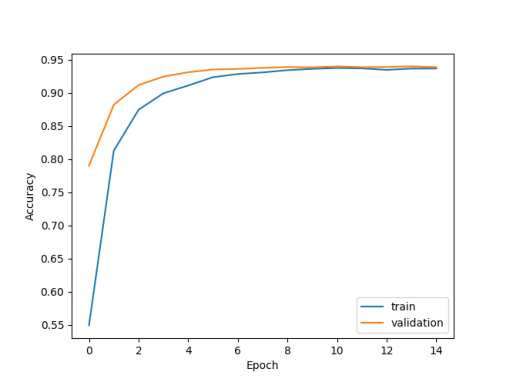

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


image = Image.open('/content/models/resnet50/accuracy-1.png')


plt.imshow(image)
plt.axis('off')
plt.show()


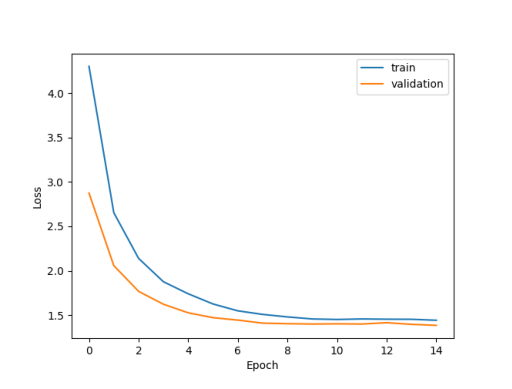

In [8]:
from PIL import Image
import matplotlib.pyplot as plt


image = Image.open('/content/models/resnet50/loss-1.png')


plt.imshow(image)
plt.axis('off')
plt.show()
